In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
fpath = "../../data/DNN_data/v3/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v3_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


In [1]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,9))
plt.subplot(3, 1, 1)
plt.plot(t, sig_with_artifact[0], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t, artifact[0], color='darkorange')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t, sig[0], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

NameError: name 'np' is not defined

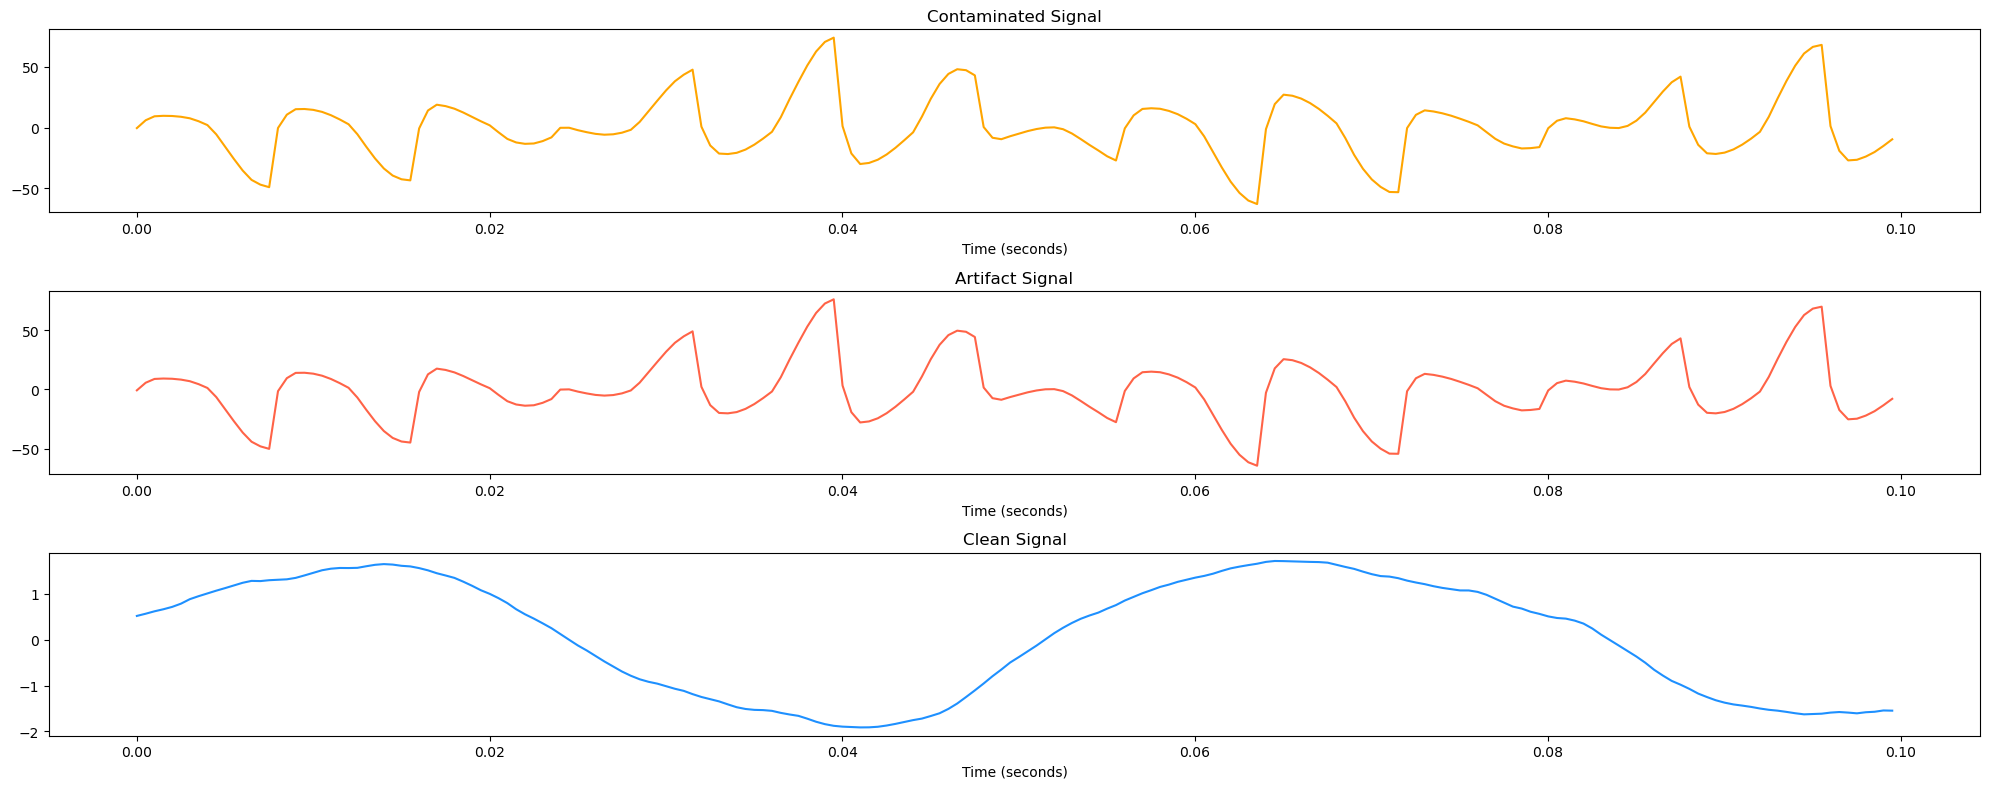

In [4]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')

plt.tight_layout()

(1000, 4000)
(1000, 4000)


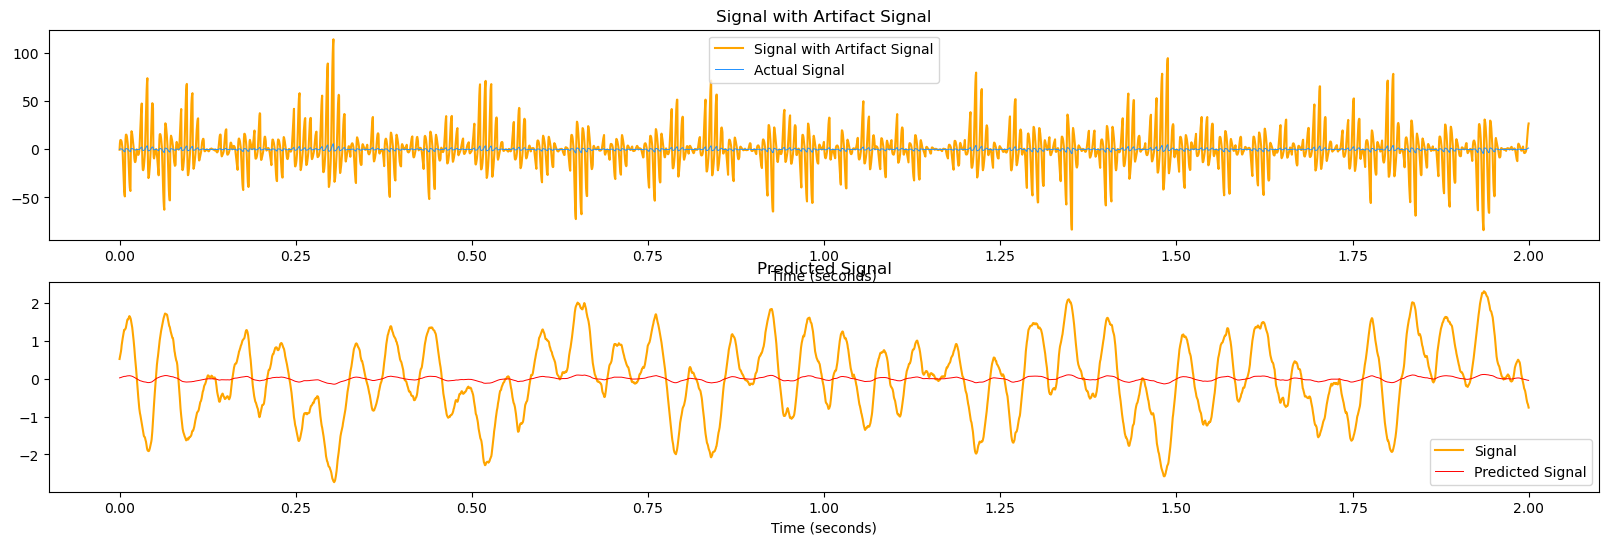

In [5]:
scaler = StandardScaler()

X = scaler.fit_transform(sig_with_artifact.T)
y = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.T
y = y.T

print(X.shape)
print(y.shape) 

plt.figure(figsize=(20,6))
plt.subplot(2, 1, 1)
plt.plot(t, sig_with_artifact[0], label='Signal with Artifact Signal', color='orange')
plt.plot(t, X[0,:], label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7) #input data
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sig[0], label='Signal', color='orange')
plt.plot(t, y[0,:], label='Predicted Signal', color='red', alpha=1, linewidth=0.7) # output data
plt.xlabel("Time (seconds)")
plt.title('Predicted Signal')
plt.legend()

plt.show()

In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 1, 4000), y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 1, 4000), y_test shape: (200, 4000)


In [7]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        x = x.squeeze(1) # x : B x T
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [8]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_spectro, y_spectro):
        signal_loss = self.mse_loss(y_pred, y)
        spectrogram_loss = self.mse_loss(y_pred_spectro, y_spectro)
        return self.alpha * signal_loss + (1 - self.alpha) * spectrogram_loss

In [9]:
# 모델 훈련
learning_rate = 0.01
criterion = LossFunction(alpha=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x T
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        n = len(y_pred)
        
        y_fft = torch.fft.fft(y)
        y_fft = torch.abs(y_fft[:n//2])
        y_fft[1:] = 2 * y_fft[1:]
        y_spectro = y_fft**2
        
        y_pred_fft = torch.fft.fft(y_pred)
        y_pred_fft = torch.abs(y_pred_fft[:n//2])
        y_pred_fft[1:] = 2 * y_pred_fft[1:]
        y_pred_spectro = y_pred_fft**2
        
        loss = criterion(y_pred, y, y_pred_spectro, y_spectro)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 27791.4453125
Epoch 10/200, Loss: 15758.23828125
Epoch 15/200, Loss: 11943.6103515625
Epoch 20/200, Loss: 10769.8896484375
Epoch 25/200, Loss: 7754.8330078125
Epoch 30/200, Loss: 8014.50439453125
Epoch 35/200, Loss: 7126.9296875
Epoch 40/200, Loss: 5140.3681640625
Epoch 45/200, Loss: 4909.45947265625
Epoch 50/200, Loss: 4831.5771484375
Epoch 55/200, Loss: 4545.77490234375
Epoch 60/200, Loss: 3696.028564453125
Epoch 65/200, Loss: 3338.971923828125
Epoch 70/200, Loss: 2874.273193359375
Epoch 75/200, Loss: 3448.28955078125
Epoch 80/200, Loss: 2826.83251953125
Epoch 85/200, Loss: 2825.31494140625
Epoch 90/200, Loss: 2501.601806640625
Epoch 95/200, Loss: 2350.878173828125
Epoch 100/200, Loss: 2186.316650390625
Epoch 105/200, Loss: 2028.7056884765625
Epoch 110/200, Loss: 2649.633544921875
Epoch 115/200, Loss: 2095.721435546875
Epoch 120/200, Loss: 2142.746826171875
Epoch 125/200, Loss: 1843.691650390625
Epoch 130/200, Loss: 1708.6131591796875
Epoch 135/200, Loss: 1669.7772

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        n = len(y_pred)
        y_fft = torch.fft.fft(y)
        y_fft = torch.abs(y_fft[:n//2])
        y_fft[1:] = 2 * y_fft[1:]
        y_spectro = y_fft**2
        
        y_pred_fft = torch.fft.fft(y_pred)
        y_pred_fft = torch.abs(y_pred_fft[:n//2])
        y_pred_fft[1:] = 2 * y_pred_fft[1:]
        y_pred_spectro = y_pred_fft**2
        loss = criterion(y_pred, y, y_pred_spectro, y_spectro)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_spectro.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_spectro.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Validation Loss: {val_loss.item()}')    
        

Validation Loss: 1753.3033447265625


Mean Absolute Error: 0.016761453822255135
Mean Squared Error: 0.0005611274391412735


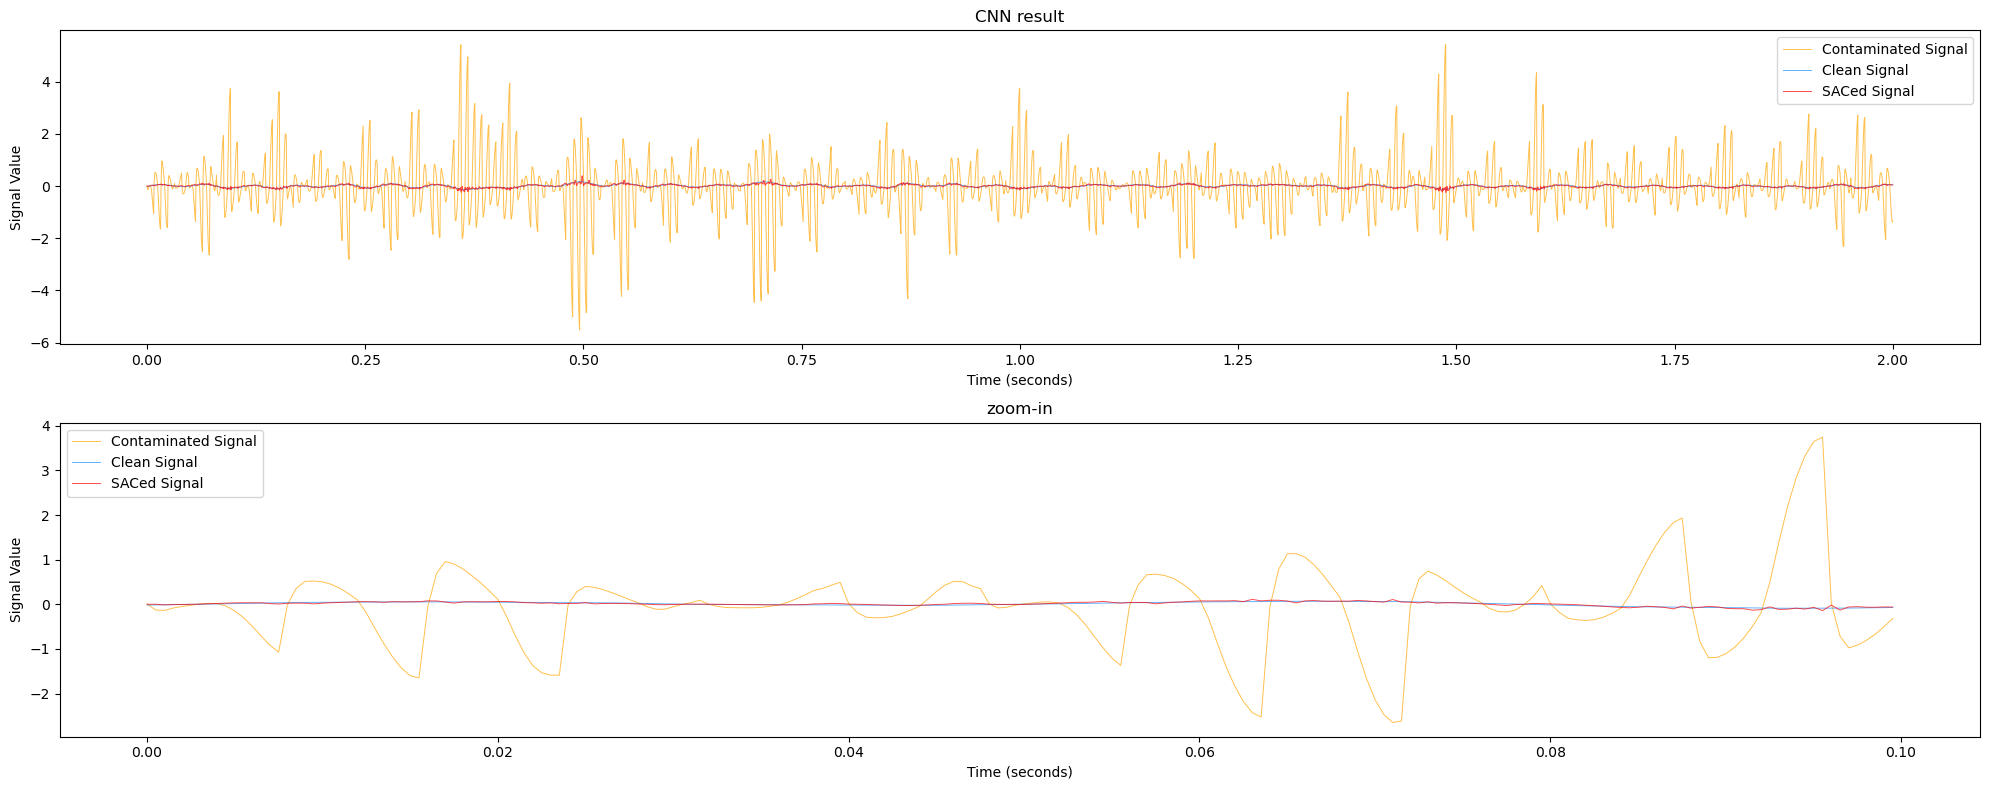

In [11]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('CNN result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

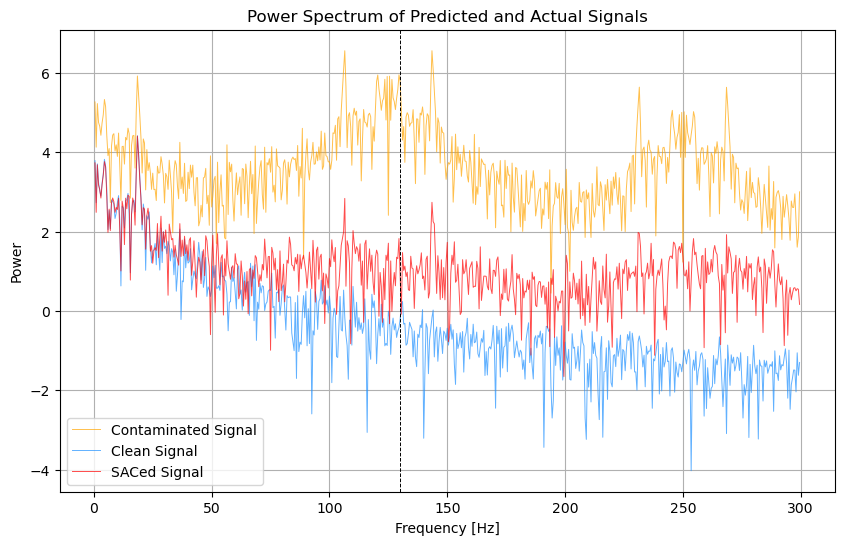

Mean Absolute Error: 2.1135641443728193
Mean Squared Error: 5.262878588220835


In [12]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(SACed_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(Clean_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(Contaminated_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.axvline(x=130, color='black', linestyle='--',label='130 Hz', linewidth=0.7)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")